In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X = data['X']
y = data['y']
X.shape, y.shape

((5000, 400), (5000, 1))

In [4]:
weight = loadmat('ex4weights.mat')
theta1, theta2 = weight['Theta1'],weight['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

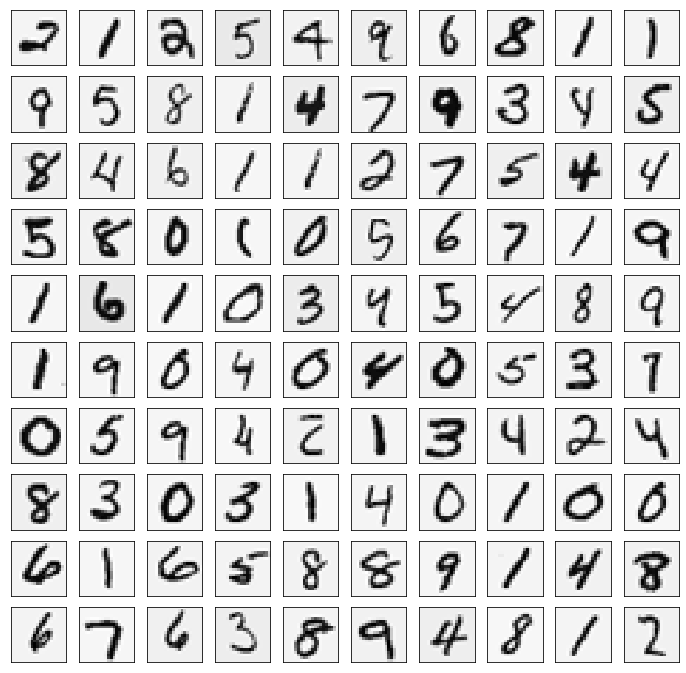

In [5]:
sample_idx = np.random.choice(np.arange(data['X'].shape[0]), 100)
sample_images = data['X'][sample_idx, :]
fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(12, 12))
for r in range(10):
    for c in range(10):
        ax_array[r, c].matshow(np.array(sample_images[10 * r + c].reshape((20, 20))).T,cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 

### forward board and cost function

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-z))


In [44]:
def forward_propagate(X,theta1,theta2):
    m = X.shape[0]
    
    a1 = np.insert(X,0,values=np.ones(m),axis=1)  # (5000,401)
    z2 = a1*theta1.T                              # (5000,25)
    a2 = np.insert(sigmoid(z2),0,values=np.zeros(m),axis=1)  # (5000, 26)
    z3 = a2 * theta2.T  # (5000, 10 )
    h = sigmoid(z3)    # (5000, 10)
    return a1, z2, a2, z3, h


In [45]:
def cost(theta1,theta2,input_size, hidden_size, num_labels,X,y,learning_rate):
        m = X.shape[0]
        X = np.matrix(X)
        y = np.matrix(y)
        
        # run the feed-forward pass
        a1, z2, a2, z3, h = forward_propagate(X,theta1, theta2)
        J=0
        for i in range(m):
            first_term = np.multiply(-y[i,:], np.log(h[i,:]))
            second_term = np.multiply((1-y)[i,:], np.log(1-h[i,:]))
            J += np.sum(first_term-second_term)
        J = J / m 
        return J
    

### for y decode
(5000,1) --> (5000,10)

In [46]:
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [47]:
y[0], y_onehot[0,:]


(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

In [48]:
# 初始化设置
input_size = 400
hidden_size = 25
num_labels = 10
learning_rate = 1

In [49]:
cost(theta1,theta2,input_size,hidden_size,num_labels,X,y_onehot,learning_rate)


0.3297269994028048

## regularization -- cost function

In [54]:
def costReg(theta1,theta2,input_size,
           hidden_size,num_labels,
           X,y,learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    # run the feed-forward pass
    a1,z2,a2,z3,h = forward_propagate(X,theta1,theta2)
    
    # compute the cost
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1-y)[i,:], np.log(1-h[i,:]))
        J += np.sum(first_term-second_term)
    J = J / m 
    
    # add the cost regularization term
    J += (float(learning_rate)/(2*m))*((np.sum(np.power(theta1[:,1:],2)))+(np.sum(np.power(theta2[:,1:],2))))
    
    return J


In [56]:
costReg(theta1,theta2,input_size,hidden_size,num_labels,X,y_onehot,learning_rate)


0.42586769333240954

### backward propagation

In [57]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z),(1-sigmoid(z)))


In [58]:
sigmoid_gradient(0)


0.25

#### random start

In [64]:
# np.random.random(size) 返回size大小的0-1随机浮点数
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.24

#### back propagation

In [66]:
def backprop(params,input_size,hidden_size,num_labels,
            X,y,learning_rate):
    m = X.shape[0]
    X = X.matrix(X)
    y = y.matrix(y)
    
    a1, z2, a2, z3, h = forward_propagate(X,theta1,theta2)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size + 1)], (hidden_size,(input_size+1))))
    theta2 = np.matrix(np.reshape(params[hidden_size*(input_size + 1):], (num_labels,(hidden_size+1))))    
    
    J = 0
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    J = J / m
    
    # perform the backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]    # (1, 10)
        yt = y[t,:]    # (1, 10)
            
        d3t = ht - yt  #(1, 10)
        
        z2t = np.insert(z2t,0,values = np.ones(1))
        d2t = np.multiply((theta2.T*d3t.T).T, sigmoid_gradient(z2t))
        
        delta1 = delta1 + (d2t[:,:]).T * a1t
        delta2 = delta2 + (d3t).T * a1t
    
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    return J, delta1, delta2

In [67]:
def backpropReg(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad



### use the scipy tooler`

In [68]:
from scipy.optimize import minimize

# minimize the objective function
fmin = minimize(fun=backpropReg, x0=(params), args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate), 
                method='TNC', jac=True, options={'maxiter': 250})
fmin


     fun: 0.33066108650587234
     jac: array([ 3.13143220e-05,  4.20189073e-07,  4.76018946e-07, ...,
        5.12984221e-06, -1.51783625e-04, -1.01309378e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 22
  status: 3
 success: False
       x: array([-5.64216173e-01,  2.10094536e-03,  2.38009473e-03, ...,
       -2.26354148e+00,  1.95488694e+00,  1.73442601e+00])